In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [50]:
stock_symbols = ['GOOG', 'MSFT', 'NVDA','AMZN','AAPL']

df_sentiment_scores_dict = {}
df_stock_data_dict = {}
sentiment_scores = {}
stock_data = {}
stock_diff_close_open = {}
rolling_window  = 14
for symbol in stock_symbols:
    # Load and convert date columns
    df_sentiment_scores_dict[symbol] = pd.read_csv(f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/Sentiment_scores/news_sentiment_scores/2000-2022/sentiment_analysis_results_{symbol}.csv')
    df_stock_data_dict[symbol] = pd.read_csv(f'/Users/rishabhbhardwaj/Desktop/Bootcamp project/stocks data/stock_data_{symbol}.csv')

    df_sentiment_scores_dict[symbol]['Date'] = pd.to_datetime(df_sentiment_scores_dict[symbol]['Date']).dt.date
    df_stock_data_dict[symbol]['Date'] = pd.to_datetime(df_stock_data_dict[symbol]['Date']).dt.date

    # Filter by date range and get common dates
    start_date, end_date = pd.to_datetime('2004-10-29').date(), pd.to_datetime('2022-09-21').date()
    filtered_sentiment = df_sentiment_scores_dict[symbol].loc[
        (df_sentiment_scores_dict[symbol]['Date'] >= start_date) & 
        (df_sentiment_scores_dict[symbol]['Date'] <= end_date)
    ]
    filtered_stock = df_stock_data_dict[symbol].loc[
        (df_stock_data_dict[symbol]['Date'] >= start_date) & 
        (df_stock_data_dict[symbol]['Date'] <= end_date)
    ]
    common_dates = set(filtered_sentiment['Date']).intersection(filtered_stock['Date'])

    # Apply common date filtering
    sentiment_scores[symbol] = filtered_sentiment.loc[filtered_sentiment['Date'].isin(common_dates), 'Weighted compound sentiment score']
    stock_data[symbol] = filtered_stock[filtered_stock['Date'].isin(common_dates)]
    
    stock_diff_close_open[symbol] = (stock_data[symbol]['Close'] - stock_data[symbol]['Open']).reset_index(drop=True)

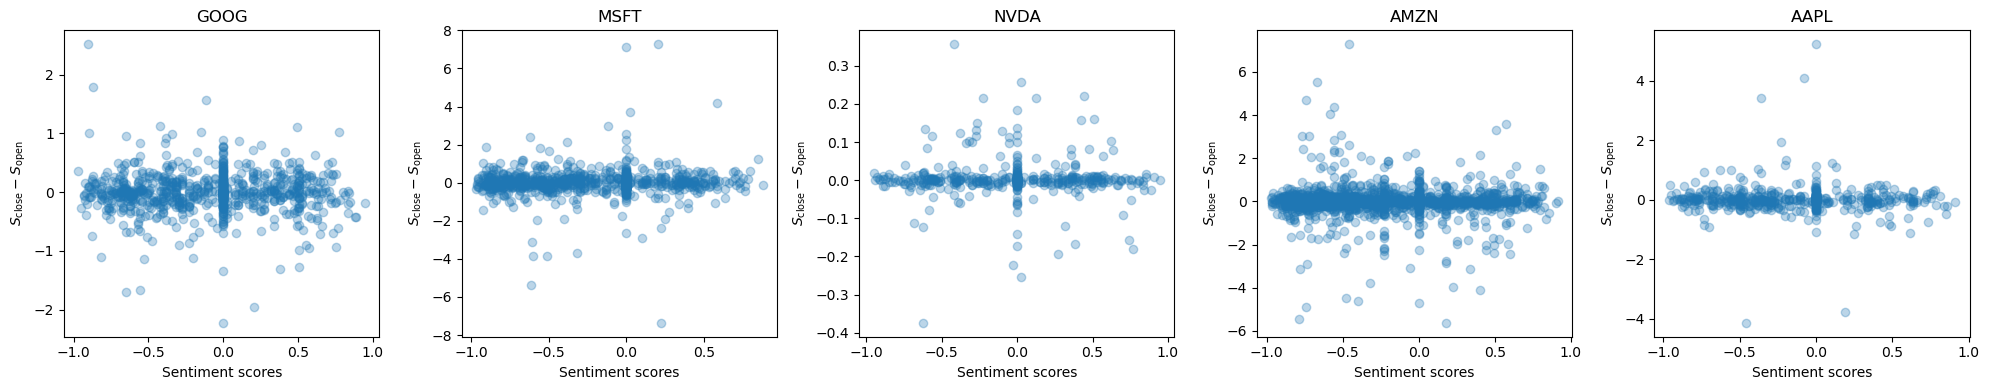

In [54]:
# Create a figure with 5 subplots arranged in a single row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust figsize as needed

# Loop through each plot and corresponding axis
for i in range(len(stock_symbols)):
    symbol = stock_symbols[i]
    axes[i].scatter(sentiment_scores[symbol],stock_diff_close_open[symbol],alpha = .3)
    axes[i].set_title(symbol)
    axes[i].set_xlabel("Sentiment scores")
    axes[i].set_ylabel(r"$S_{\text{close}}-S_{\text{open}}$")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


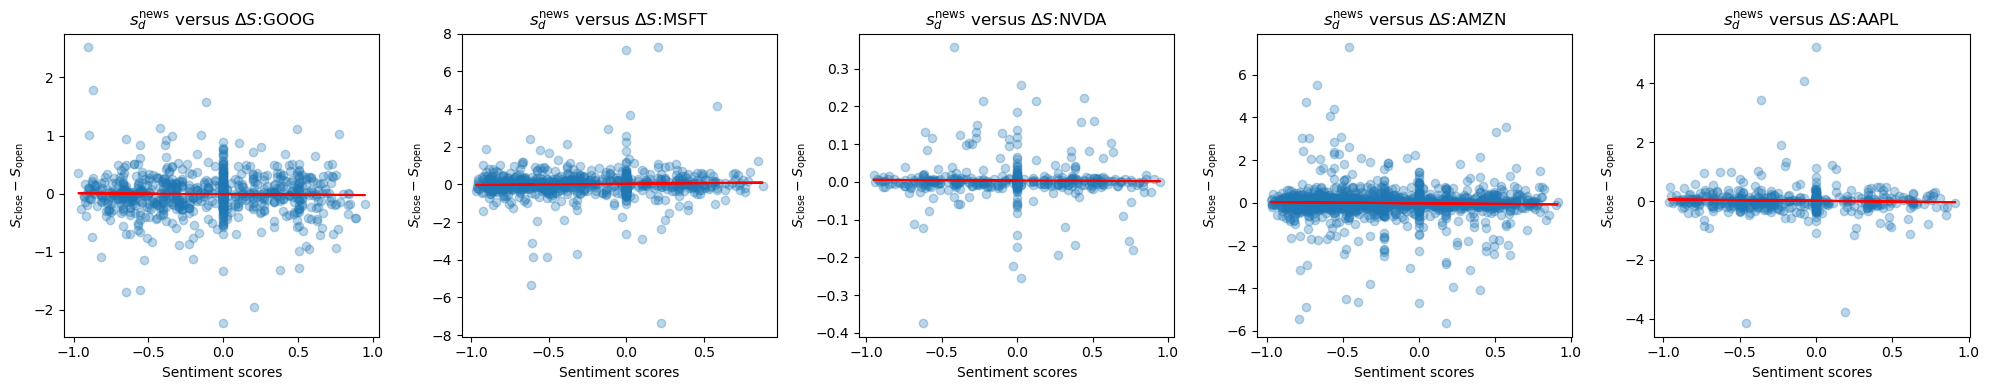

In [55]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse

# Create a figure with 5 subplots arranged in a single row
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # Adjust figsize as needed

# Loop through each plot and corresponding axis
model = {}
mses = {}
for i in range(len(stock_symbols)):
    symbol = stock_symbols[i]
    # Reshape your data if needed
    X = np.array(sentiment_scores[symbol][rolling_window-1:]).reshape(-1, 1)  # Sentiment scores as predictor
    y = np.array(stock_diff_close_open[symbol][rolling_window-1:])

    model[symbol] = LinearRegression().fit(X, y)
    y_pred = model[symbol].predict(X)
    mses[symbol] = mse(y, y_pred)
    
    axes[i].scatter(sentiment_scores[symbol][rolling_window-1:],stock_diff_close_open[symbol][rolling_window-1:],alpha = .3)
    axes[i].plot(sentiment_scores[symbol][rolling_window-1:],y_pred,color = "red")
    
    axes[i].set_title(r"$s^{\text{news}}_d$ versus $\Delta S$:" f"{symbol}")
    axes[i].set_xlabel("Sentiment scores")
    axes[i].set_ylabel(r"$S_{\text{close}}-S_{\text{open}}$")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [56]:
# Fit via statsmodel 
import statsmodels.api as sm

X_goog = np.array(sentiment_scores['GOOG'][rolling_window-1:])
y_goog = np.array(stock_diff_close_open['GOOG'][rolling_window-1:])

X_with_const = sm.add_constant(X_goog)

model_ols = sm.OLS(y_goog, X_with_const)
results = model_ols.fit()

# Print the summary to see coefficients and other statistics
print(results.summary())

# Get the confidence intervals for the coefficients
confidence_intervals = results.conf_int(alpha=0.05)  # 95% CI by default
print("Confidence intervals:\n", confidence_intervals)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.3392
Date:                Wed, 06 Nov 2024   Prob (F-statistic):              0.560
Time:                        00:48:05   Log-Likelihood:                -322.42
No. Observations:                 834   AIC:                             648.8
Df Residuals:                     832   BIC:                             658.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0090      0.013     -0.711      0.4

In [57]:
for symbol in stock_symbols:
    print([model[symbol].coef_,model[symbol].intercept_])

[array([-0.01638084]), np.float64(-0.009030359421374845)]
[array([0.0701476]), np.float64(0.03160097329066806)]
[array([-0.00182753]), np.float64(0.003643844822428552)]
[array([-0.05480741]), np.float64(-0.019030657107133475)]
[array([-0.04974112]), np.float64(0.008356607987214278)]


In [58]:
mses

{'GOOG': np.float64(0.12685906000215377),
 'MSFT': np.float64(0.5703098415913918),
 'NVDA': np.float64(0.0029971420653868994),
 'AMZN': np.float64(0.48152696866198336),
 'AAPL': np.float64(0.25901812046661044)}

In [9]:
# import KNeighborsRegressor
from sklearn.neighbors import KNeighborsRegressor

In [10]:
kNN_model = KNeighborsRegressor(2)
X_fit = np.linspace(x.min(), x.max(), 432).reshape(-1, 1)

kNN_model.fit(X_fit, y.reshape(-1,1))
y_pred_knn= kNN_model.predict(X_fit)

plt.scatter(x, y,alpha = .3,label="Stock Price & News Data")
plt.plot(X_fit,y_pred_knn,'k',label="KNR")

plt.xlabel('Sentiment scores')
plt.ylabel('Stock opening and closing price difference')
plt.legend(fontsize=12)
plt.title("kNN Regression of Sentiment Scores vs Stock Price Difference")
plt.show()

NameError: name 'x' is not defined

In [289]:
mse_knn = mean_squared_error(y, y_pred_knn)
print("Mean Squared Error:", mse_knn)

Mean Squared Error: 0.032194388527403986


In [295]:
kNN_model.predict([[0.85]])

array([[0.09071422]])

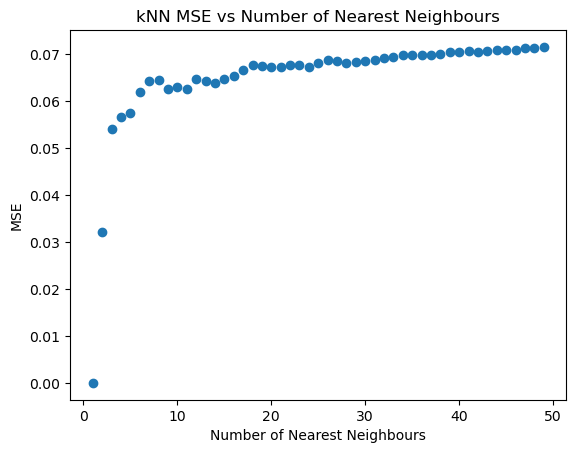

In [292]:
mse_lst = []
k_lst = np.arange(1,50)
for k in k_lst:    
    kNN_model = KNeighborsRegressor(k)
    X_fit = np.linspace(x.min(), x.max(), 432).reshape(-1, 1)

    kNN_model.fit(X_fit, y.reshape(-1,1))
    y_pred_knn= kNN_model.predict(X_fit)
    mse_knn = mean_squared_error(y, y_pred_knn)
    mse_lst.append(mse_knn)

plt.title("kNN MSE vs Number of Nearest Neighbours")
plt.scatter(k_lst,mse_lst)
plt.xlabel("Number of Nearest Neighbours")
plt.ylabel("MSE")
plt.show()

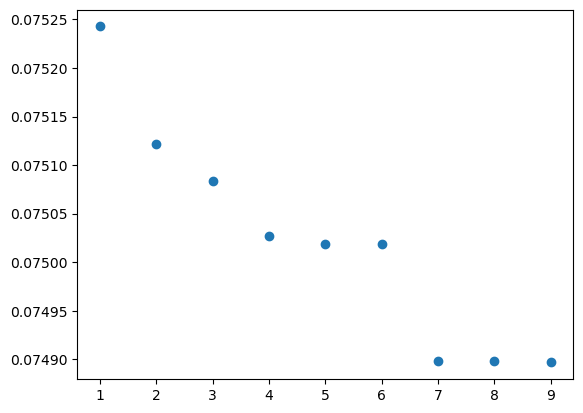

In [274]:
from numpy.polynomial.polynomial import Polynomial

# Fit a polynomial model (e.g., degree 2)

MSE_lst_pol = []
for d in range(1,10):
    poly_model = Polynomial.fit(x, y, deg=d)
    y_pred = poly_model(X)

    # Calculate MSE
    mse_pol = mean_squared_error(y, y_pred)
    MSE_lst_pol.append(mse_pol)
plt.scatter(np.arange(1,10), MSE_lst_pol)